## The Hilbert and Hilbert-Huang Transform

### Paul Anzel DATEDATEDATE

A problem with the Fourier transform (and related techniques) is that they're *stationary* methods--specifically, they assume that nothing actually changes in time, it's all just waves perpetually going in to and out of phase. A Fourier series of a music file will tell you that there's a lot of $A \flat$'s and middle $C$'s, but nothing about when they happen, and it assumes that, like some demented fool, you've decided to play "The Boys are Back in Town" over and over on to infinity--and that you've been playing that song since time immemorial. You can ignore this fact in practice, but it is a weird conceptual issue. 

Or, for a simpler case, assume that you've briefly turned on and off a light-switch. The Fourier transform assumes that the light is always emitting various frequencies, from before you were born until well past the collapse of civilization (and perhaps the demolishing of the light) but it *just so happens* that at all of these times the various frequencies were cancelling each other out until the magic moment that the light is turned on.

In [1]:
import numpy as np
import scipy as sp
from scipy.fftpack import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

from scipy.signal import hilbert, savgol_filter

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


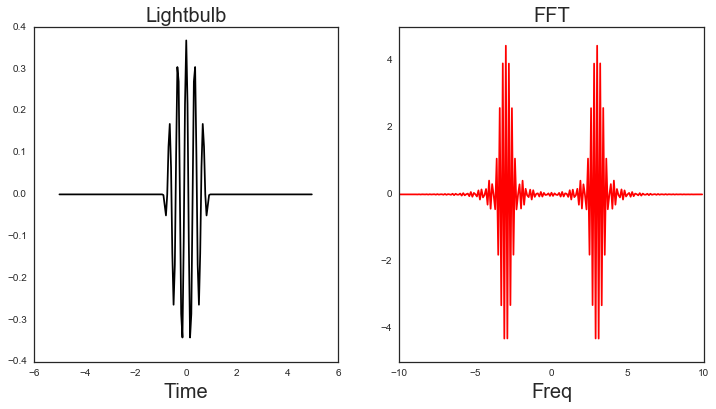

In [2]:
x_light = np.arange(-5, 5, 0.05)

# This is a bump function, so we have a nice turn off-and-on
_f = lambda x: np.exp(-1.0/(1.0-x*x))
f = lambda x: np.piecewise(x, [np.abs(x) < 1, np.abs(x) >= 1], [_f, 0.0])

y_light = np.cos(x_light*6*np.pi)
y_light = y_light*f(x_light)
y_fft = fft(y_light)
x_fft = fftfreq(len(x_light), 0.05)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].plot(x_light, y_light, color='k')
axes[0].set_title('Lightbulb', fontsize=20)
axes[0].set_xlabel('Time', fontsize=20)
axes[1].plot(fftshift(x_fft), fftshift(y_fft), color='r')
axes[1].set_xlabel('Freq', fontsize=20)
axes[1].set_title('FFT', fontsize=20)

This is weird. You'd think that, maybe if you filtered the light just right, you could cancel this out (you can't without breaking causality$^*$ but that's another issue) and see the light turning off and on.

There are various ways to deal with this; the most common is to window your signal (multiply it by a function that goes to 0 around some point $t$) and take transforms of the signal at different points in time (much like the song visualizers you might see in Winamp and iTunes), giving a *spectrogram*. Other technique include wavelet analysis and using the Wigner distribution function.

A final way, and our technique of interest here, is to take a Hilbert transform.

$^*$And this causality leads to the [Kramers-Kronig relations](https://en.wikipedia.org/wiki/Kramers%E2%80%93Kronig_relations), which is another Hilbert transform.

### Definition

The Hilbert transform of a function $f(t)$ is the transformation

$$ \mathcal{H}(f)(t) = \frac{1}{\pi} PV \int_{-\infty}^{\infty} \frac{f(\tau)}{t - \tau} d\tau $$ 

...so you're convolving your function $f(t)$ with the kernel $K(t) = 1/(\pi t$).

The *PV* in the above equation means Principal Value, which basically is telling you that for the part where $\tau$ is near $t$, you take an integral with $\tau$ going to $t - \epsilon$ and $t + \epsilon$ with the limit $\epsilon \rightarrow 0$. If you wanted to actually solve this for selected functions, you'd probably be using complex analysis with the Residue Theorem and talk about test functions going to 0 at infinity.

That is a problem for the mathematicians, and is not something we need to bother with. We can get some basic understanding by looking at tables of transforms [e.g. at Wikipedia](https://en.wikipedia.org/wiki/Hilbert_transform#Table_of_selected_Hilbert_transforms), and most critically understanding that the transform of a cosine gives a sine (at the same frequency) and the transform of a sine gives a negative cosine (same frequency).

Plus, we're going to be dealing with numeric data. So you're going to have some convolution kernel like

$$[..., -1/5, -1/4 -1/3, -1/2, -1, 0, 1, 1/2, 1/3, 1/4, 1/5, ...]/\pi$$

and you can ignore any weirdness about the $1/t$ blowup and stuff out at infinity.

Given a Hilbert transform of a function, one will then often create a function $\tilde{f}(t) = f(t) + i\mathcal{H}(f)(t)$, which is called the __analytic signal__.

### Okay, why do we care?

The cosine $\leftrightarrow$ sine bit of the Hilbert Transform and how we make the analytic signal looks a lot like using the Euler identity $\cos(\theta) + i\sin(\theta) = e^{i \theta}$. So we can think about this as writing our Analytic Signal as $\tilde{f}(t) = A(t)e^{i \theta(t) t}$. Then $A(t)$ gives us the __envelope__ of our signal (our signal is oscillating between the envelope) and $\frac{d}{dt}\theta(t)$ is our __instantaneous frequency__ (Specifically, angular frequency. Divide by $2\pi$ if you want normal frequency).$^*$ These are useful things to deal with.

$^*$Actually, this requres the time-scale that $A(t)$ changes at to be much slower than $e^{i \theta(t) t}$. This is based on something called the Bedrosian Theorem and some refinements to the basic ideas above are discussed [on page 6 here](http://www.msri.org/people/members/2008cc/Projects/Project_5B_Ice_Core_EMD/HuangWu_EMD_RevGeo_2008.pdf). But, for now, the above explanation is good enough.

#### Example: Chirp signal

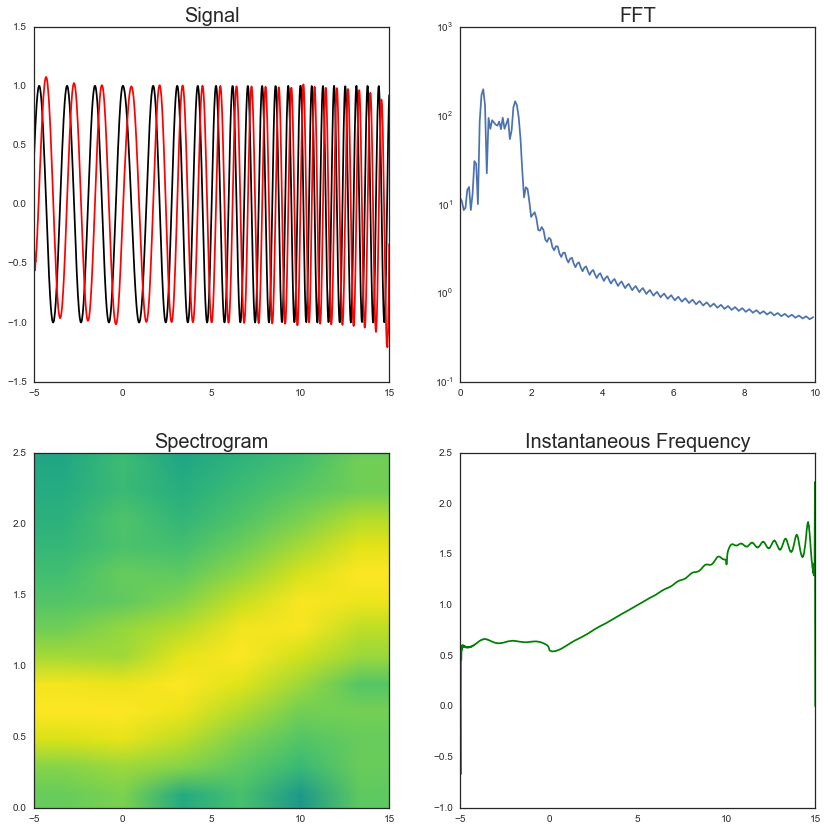

In [3]:
from scipy.signal import chirp

x_chirp = np.linspace(-5, 15, 1000)
dx = x_chirp[1]-x_chirp[0]
# chirp_index = np.logical_and(x_chirp > 0, x_chirp <= 10)
y_chirp = chirp(x_chirp, 0.5, 10, 1.5, method='linear')
y_chirp[x_chirp <= 0] = np.cos(4*x_chirp[x_chirp <= 0])
y_chirp[x_chirp >= 10] = np.cos(10*x_chirp[x_chirp >= 10]+np.pi/8)
fft_chirp = fft(y_chirp)
fftfreqs = fftfreq(len(x_chirp), dx)

ya_chirp = hilbert(y_chirp)

phase_chirp = np.angle(ya_chirp)
phase_chirp = np.unwrap(phase_chirp)
instant_freq = savgol_filter(phase_chirp, 3, 1, deriv=1, delta=dx, mode='mirror')/(2*np.pi)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axes[0,0].plot(x_chirp, y_chirp, color='k')
axes[0,0].plot(x_chirp, np.imag(ya_chirp), color='r')
axes[0,0].set_title('Signal', fontsize=20)
axes[0,1].semilogy(fftfreqs[:200], np.abs(fft_chirp[:200]))
axes[0,1].set_title('FFT', fontsize=20)
axes[1,1].plot(x_chirp, instant_freq, color='g')
axes[1,1].set_title('Instantaneous Frequency', fontsize=20)

axes[1,0].specgram(y_chirp, Fs=(1.0/dx), xextent=[-5, 15],cmap=plt.cm.viridis)
axes[1,0].set_ylim([0.0, 2.5])
axes[1,0].set_title('Spectrogram', fontsize=20)

The Fourier Transform clearly shows our frequencies going between 0.6 and 1.6, but doesn't tell us when. The spectrogram shows us the time at which we're at different frequencies, but is fuzzy. The Hilbert Transform, on the other hand, really clearly shows the frequencies at different times, though it has some issues at the boundaries (which could be addressed by mirroring the signal at the end points).

#### Example: Decaying signal

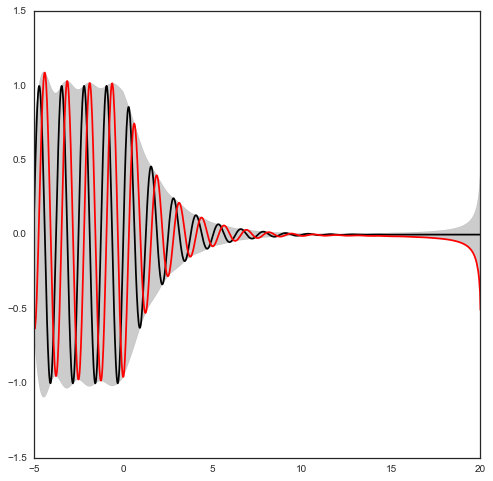

In [4]:
x_decay = np.linspace(-5, 20, 1000)
y_decay = np.exp(-0.5*x_decay)*np.sin(5*x_decay)
y_decay[x_decay < 0] = np.sin(5*x_decay[x_decay < 0])

ya_decay = hilbert(y_decay)
envelope = np.abs(ya_decay)

plt.figure(figsize=(8,8))
plt.plot(x_decay, y_decay, color='k')
plt.plot(x_decay, np.imag(ya_decay), color='r')
plt.fill_between(x_decay, -envelope, envelope, color='k', alpha=0.2)

Once again some weirdness at the boundaries (scipy calculates the signal by treating it as periodic, rather than giving the option to mirror) but the decay envelope starting at $t = 0$ is very clear. Since this weirdness-at-the-boundaries is getting to me, let's write our own function to do the mirroring.

In [5]:
def mirror_hilbert(x, reflect_x=True):
    # x should be a (N,) array, but in case you didn't do that
    x = x.ravel()
    N = len(x)
    if reflect_x:
        ref_term = -1
    else:
        ref_term = 1
    mirror_x = np.empty(3*N)
    mirror_x[:N] = ref_term*x[::-1]
    mirror_x[N:(2*N)] = x
    mirror_x[(2*N):] = ref_term*x[::-1]
    y = hilbert(mirror_x)
    ret_y = y[N:(2*N)]
    return ret_y

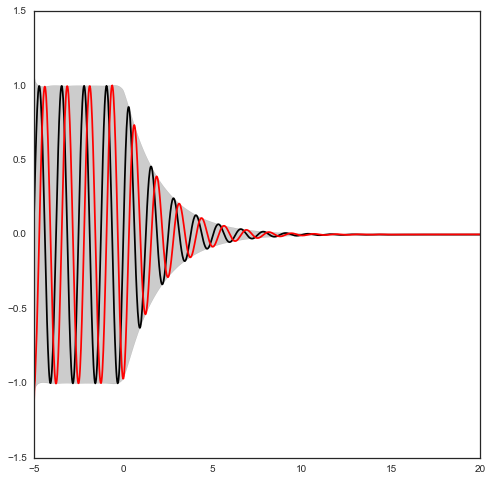

In [6]:
ya_decay2 = mirror_hilbert(y_decay, reflect_x=True)
envelope2 = np.abs(ya_decay2)

plt.figure(figsize=(8,8))
plt.plot(x_decay, y_decay, color='k')
plt.plot(x_decay, np.imag(ya_decay2), color='r')
plt.fill_between(x_decay, -envelope2, envelope2, color='k', alpha=0.2)

This is significantly cleaner. Note that I set the signal to be reflected in the y-axis for this example, as this more cleanly matches what the signal is doing at $t=-5$.

#### Example: Lightbulb

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


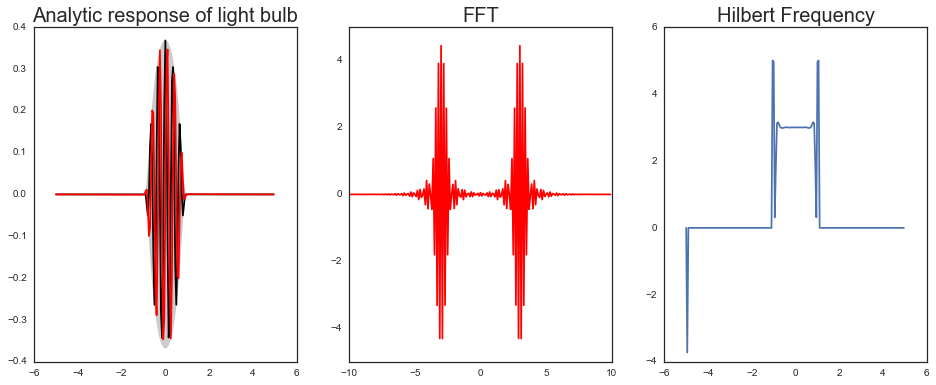

In [7]:
ya_light = hilbert(y_light)

light_phase = np.unwrap(np.angle(ya_light), discont=5)
envelope = np.abs(ya_light)
instant_freq = savgol_filter(light_phase, 3, 1, deriv=1, delta=x_light[1]-x_light[0], mode='mirror')/(2*np.pi)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
axes[0].plot(x_light, y_light, color='k')
axes[0].plot(x_light, np.imag(ya_light), color='r')
axes[0].fill_between(x_light, -envelope, envelope, color='k', alpha=0.2)
axes[0].set_title('Analytic response of light bulb', fontsize=20)
axes[1].plot(fftshift(x_fft), fftshift(y_fft), color='r')
axes[1].set_title('FFT', fontsize=20)
axes[2].plot(x_light, instant_freq)
axes[2].set_title('Hilbert Frequency', fontsize=20)

### Note:

Scipy has two Hilbert transform functions, [`scipy.fftpack.hilbert`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.fftpack.hilbert.html) and [`scipy.signal.hilbert`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.hilbert.html). It looks like the signal one is a bit more useful than the fftpack one.

### Properties of the Hilbert Transform and Analytic Signal

- $\mathcal{H}(\mathcal{H}(f(t)) = -f(t)$, up to a constant factor (and we'll get there in a bit...).
- In Fourier space, the Hilbert transform multiplies the Fourier transform by $i \times \text{sgn}(\nu)$. The transform to the analytic signal multiplies the Fourier transform by $2*\Theta(t)$ where $\Theta$ is the Heaviside function (0 at $t<0$, 1 at $t>0$). This means that we've basically cut out all of the negative frequency components of a signal.
- The instantaneous frequency **BEATS** the Gabor limit $\sigma_t \sigma_{\nu} \geq 1/4\pi$. If I was trying to use a spectrogram to figure out what frequency is happening right at the moment, I'd have to balance the width of the window--too wide and it's hard to tell exactly when something is happening, too narrow and I can't really distinguish between frequencies. We don't have that problem with the Hilbert transform.
- The Hilbert transform is scale invariant--if we have a function $f_b(t) = f(bt)$, its Hilbert transform $\mathcal{H}(f_b)(t) = \mathcal{H}(f)(bt)$. Hence, I can blithely apply the Hilbert transforms (as above) and not have to worry about the $\Delta x$ spacing.

### We run into some difficulties...

The "up to a constant factor" I mentioned in the first property ends up giving us some real headaches. For example, let's look at the function $f(t) = a + \sin(\pi t)$, where we adjust the constant factor $a$ (so we're looking at different reference values).

#### $a = 0$ (the case that works)

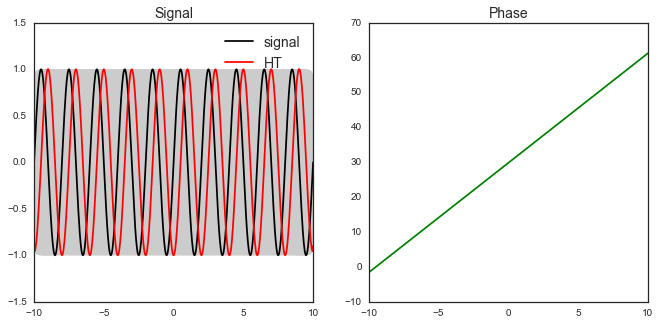

In [8]:
x_test = np.linspace(-10, 10, 600)
y_test = np.sin(np.pi*x_test) + 0.0
ya_test = mirror_hilbert(y_test)
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq0 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

#### $a = 0.5$ (the functions are offset slightly)

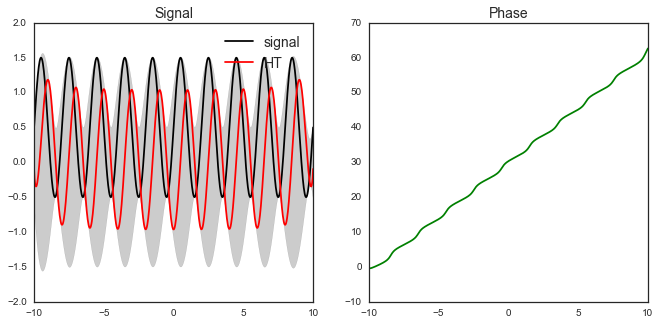

In [9]:
x_test = np.linspace(-10, 10, 600)
y_test = np.sin(np.pi*x_test) + 0.5
ya_test = mirror_hilbert(y_test, reflect_x=False)
# Needed to be set to false here due to constant term
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq03 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

#### $a = 1.2$ (we don't even hit 0)

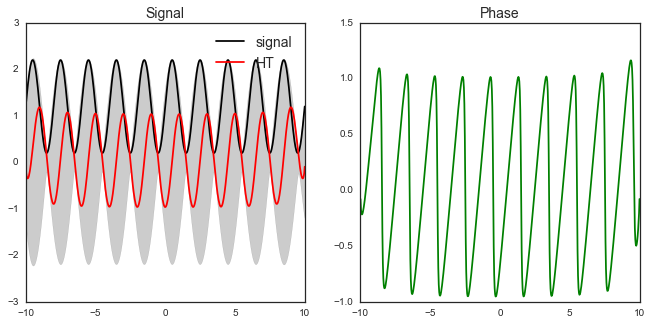

In [10]:
x_test = np.linspace(-10, 10, 600)
y_test = np.sin(np.pi*x_test) + 1.2
ya_test = mirror_hilbert(y_test, reflect_x=False)
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq12 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

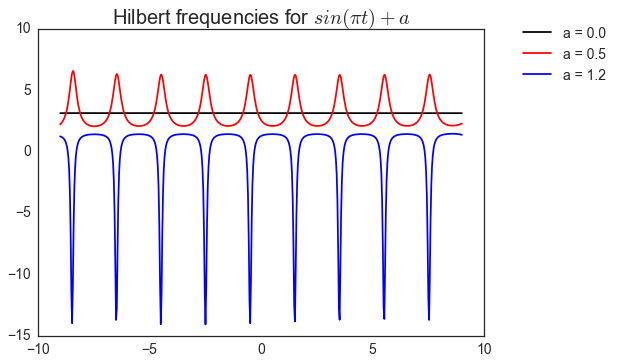

In [11]:

plt.plot(x_test[30:-30], instant_freq0[30:-30], 'k', label='a = 0.0')
plt.plot(x_test[30:-30], instant_freq03[30:-30], 'r', label='a = 0.5')
plt.plot(x_test[30:-30], instant_freq12[30:-30], 'b', label='a = 1.2')
plt.legend(bbox_to_anchor=(1.3, 1.05), fontsize=14)
plt.tick_params(labelsize=14)
plt.title(r'Hilbert frequencies for $sin(\pi t) + a$', fontsize=20)

#### Additionally, if we have two dominant frequencies superimposed, we also see odd behavior

$y = \sin(\pi x/2) + 0.5 \cos(\pi x)$

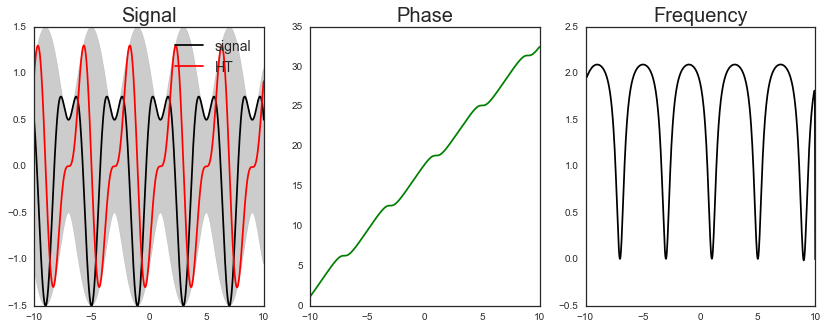

In [12]:
y_test2 = np.sin(np.pi*x_test/2) + 0.5*np.cos(np.pi*x_test)
ya_test2 = hilbert(y_test2)
# Signal is purely periodic, so not using mirror_hilbert

envelope = np.abs(ya_test2)
phaseterm = np.unwrap(np.angle(ya_test2))
instant_freq2 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5))

axes[0].plot(x_test, np.real(ya_test2), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test2), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
# axes[0].plot(x_test, envelope, color='k', alpha=0.6, linestyle=':', label='envelope')
# axes[0].plot(x_test, -envelope, color='k', alpha=0.6, linestyle=':')
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=20)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=20)
axes[2].plot(x_test, instant_freq2, color='k')
axes[2].set_title('Frequency', fontsize=20)

### The Hilbert-Huang Transform

These problems were addressed by Norden Huang in [this paper](http://rspa.royalsocietypublishing.org/content/454/1971/903). The fundamental problem is that the Hilbert Transform works well provided you've got a signal that is centered around 0, and with zero crossings between the minima and maxima.

So, we try and decompose our input signal into a collection of functions, called __Intrinsic Mode Functions__ (or IMFs) that *are* Hilbert-able.

The procedure works as follows:
- Take your signal, and compute two cubic splines--one that hits all the local maxima and one that hits all the local minima. These are our "signal envelope".
- Take the mean of these two splines and subtract it from the signal.
- The remaining signal is not necessarily Hilbert-able, but is closer to being so; we've centered the signal around 0 and the old minima and maxima should alternate on either side of 0, but our subtraction of the envelope mean may have caused new minima or maxima to occur.
- From this signal, repeat the splines-and-subtract-mean process again and again. There's a couple of different stopping rules in the literature, but basically you'll stop when either the signal does not change appreciably from one iteration to another (Cauchy stoppage rules) or the number of zero-crossings and extrema are within a value of 1 and stay the same after *S* iterations (S stoppage). Both rules are explained more [here](http://www.msri.org/people/members/2008cc/Projects/Project_5B_Ice_Core_EMD/HuangWu_EMD_RevGeo_2008.pdf).
- The signal you're left with is the first IMF, and gives good results under a Hilbert Transform.
- Subtract the first IMF from the data, and then repeat the whole splines-mean-repeat process to get the second IMF, third IMF, and so on.
- You'll stop getting IMFs when your remaining signal is either constant, monotonic or has at most one extremum. This is the residue, and is often thought of as the general trend.

This whole process is called the __Emperical Mode Decomposition__.

### Let's see this in action!

[One application](https://web.cs.dal.ca/~tt/CSCI690611/papers/plugin-huan_asmbi_2003.pdf) proposed by Huang and others is in financial data, which we know is definitely non-stationary and probably a poor candidate for simple Fourier analysis.

I've been sticking most of my IRA money into Vanguard Index Funds since 2013, so it's probably best for me to learn something about what's happening to it.

In [13]:
import pandas.io.data as web
import datetime as dt

start = dt.datetime(2013, 5, 1)
end = dt.datetime(2016, 5, 1)

vti = web.DataReader("VTI", "google", start, end)
# Blah blah blah pandas wants me to install pandas_datareader, this still works for now...
vti = vti['Close'] # I'll just keep opening prices

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [14]:
vti.head()

Date
2013-05-01    81.42
2013-05-02    82.27
2013-05-03    83.04
2013-05-06    83.36
2013-05-07    83.82
Name: Close, dtype: float64

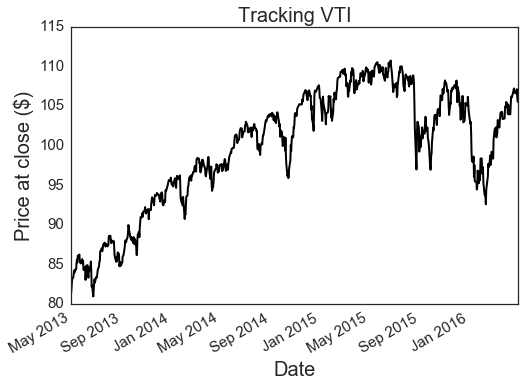

In [15]:
vti.plot(color='k', linewidth=2, fontsize=15)
plt.title("Tracking VTI", fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Price at close ($)", fontsize=20)

In [16]:
X0 = np.array(vti)
print(X0[:5])
dummy_t = np.arange(len(X0))  # So I don't have to futz with dates
vti_dates = vti.index

[ 81.42  82.27  83.04  83.36  83.82]


In [17]:
minima = sp.signal.argrelmin(X0)
maxima = sp.signal.argrelmax(X0)

minima_x = X0[minima]
minima_t = dummy_t[minima]

maxima_x = X0[maxima]
maxima_t = dummy_t[maxima]

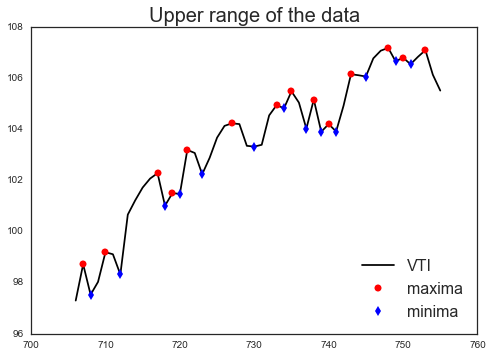

In [18]:
boundary_N = -50
restricted_t = dummy_t[boundary_N]
bnd_max_t = maxima_t > restricted_t
boundary_max_t = maxima_t[bnd_max_t]
boundary_max_x = maxima_x[bnd_max_t]

bnd_min_t = minima_t > restricted_t
boundary_min_t = minima_t[bnd_min_t]
boundary_min_x = minima_x[bnd_min_t]

plt.plot(dummy_t[boundary_N:], X0[boundary_N:], color='k', label='VTI')
plt.plot(boundary_max_t, boundary_max_x, linewidth=0, marker='o', color='r', label='maxima')
plt.plot(boundary_min_t, boundary_min_x, linewidth=0, marker='d', color='b', label='minima')
plt.legend(fontsize=16, loc=4)
plt.title('Upper range of the data', fontsize=20)

But wait! How do we deal with the boundaries here? The minima and maxima functions don't point to the boundaries (which is good, those aren't necessarily minima or maxima) but if we want to do a cubic spline, we need a point at the boundary or outside of the data range in order to extend the spline. Some [potential options taken](http://www.worldscientific.com/doi/abs/10.1142/S1793536909000047) (free pdf [here](ftp://eos.atmos.washington.edu/pub/dennis/552_Class/Wu_Huang_EEMD_2005.pdf)) have been:
- Only really look at the data far away from the boundaries. However, as we'll see in a bit, once you've gotten rid of some high-frequency components of your data, your extrema will be pretty close to the center and this might not be a great approach. Plus, we're probably interested data by the boundaries (I want to know what my retirement portfolio is going to do next! I can't just lop off the last two months...).
- Mirror the data at the boundaries. We'd imagine that by reflecting the data we get a "similar data process" right by the boundary. However, this artifically introduces an extrema at the boundary point (well, you could get rid of this one, but that may be a judgement call), and the other extrema is at the exact same height as its previous image, which isn't necessarily justifiable.
- Mirror and invert the data at the boundaries (and possibly translate it to match). We don't have the extrema showing up right at the boundary, but we're again making some pretty big assumptions about the location of extrema

And, as we can see with our simple Hilbert transforms above, it was tricky enough to pick a mirror or mirror-and-invert approach uniformly without having to fuss a little bit with our data and make a judgement call.

- Try and infer upcoming data using techniques like Fourier analysis, GARCH, Neural Networks, etc. But at this point you're doing an entirely different (and complicated) analysis, and some models (e.g. Fourier, ARMA...) assume stationarity--which is not necessarily justifiable.

In the end, the strategy suggested in Wu and Huang's 2009 Ensemble Empirical Mode Decomposition paper (link above) is as follows:
1. For both the minima and maxima, take the last two points (same type of extrema) before the boundary and draw a line between them.
  - This isn't explicitly stated, but if you have only one minima or maxima you'll probably want to just extend a flat line in both directions.
2. Look and see where these lines hit the boundary.
3. If the data rises rises above the maxima line at the boundary (or below the minima line), use that as the boundary maxima (/minima). Otherwise use the point where the line hits the boundary as the maxima (/minima).

In [19]:
def get_IMF_extrema(t, x):
    noneoutput = (None, None, None, None)
    minima = sp.signal.argrelmin(x)
    maxima = sp.signal.argrelmax(x)
    if isinstance(minima, tuple):
        minima = minima[0]
    if isinstance(maxima, tuple):
        maxima = maxima[0]

    if not len(minima):
        print('No minima present')
        return noneoutput
    if not len(maxima):
        print('No maxima present')
        return noneoutput

    if len(minima) == 1:
        trial_xmin_start = x[minima]
        trial_xmin_end = x[minima]
    else:
        xmin_1 = x[minima][0]
        xmin_2 = x[minima][1]
        tmin_1 = t[minima][0]
        tmin_2 = t[minima][1]
        min_start_slope = (xmin_2 - xmin_1)/(tmin_2 - tmin_1)
        # x - x0 = m(t - t0)
        # x = m(t - t0) + x0
        trial_xmin_start = min_start_slope*(t[0] - tmin_1) + xmin_1

        xmin_n1 = x[minima][-1]
        xmin_n2 = x[minima][-2]
        tmin_n1 = t[minima][-1]
        tmin_n2 = t[minima][-2]
        min_end_slope = (xmin_n2 - xmin_n1)/(tmin_n2 - tmin_n1)
        trial_xmin_end = min_end_slope*(t[-1] - tmin_n1) + xmin_n1
    
    if len(maxima) == 1:
        trial_xmax_start = x[maxima]
        trial_xmax_end = x[maxima]
    else:
        xmax_1 = x[maxima][0]
        xmax_2 = x[maxima][1]
        tmax_1 = t[maxima][0]
        tmax_2 = t[maxima][1]
        max_start_slope = (xmax_2 - xmax_1)/(tmax_2 - tmax_1)
        trial_xmax_start = max_start_slope*(t[0] - tmax_1) + xmax_1

        xmax_n1 = x[maxima][-1]
        xmax_n2 = x[maxima][-2]
        tmax_n1 = t[maxima][-1]
        tmax_n2 = t[maxima][-2]
        max_end_slope = (xmax_n2 - xmax_n1)/(tmax_n2 - tmax_n1)
        trial_xmax_end = max_end_slope*(t[-1] - tmax_n1) + xmax_n1

    xmin_start = x[0] if x[0] < trial_xmin_start else trial_xmin_start
    xmax_start = x[0] if x[0] > trial_xmax_start else trial_xmax_start
    xmin_end = x[-1] if x[-1] < trial_xmin_end else trial_xmin_end
    xmax_end = x[-1] if x[-1] > trial_xmax_end else trial_xmax_end
    
    minima_x = np.array([xmin_start] + list(x[minima]) + [xmin_end])
    minima_t = np.array([t[0]] + list(t[minima]) + [t[-1]])
    maxima_x = np.array([xmax_start] + list(x[maxima]) + [xmax_end])
    maxima_t = np.array([t[0]] + list(t[maxima]) + [t[-1]])
    return minima_x, minima_t, maxima_x, maxima_t

In [20]:
minima_x, minima_t, maxima_x, maxima_t = get_IMF_extrema(dummy_t, X0)

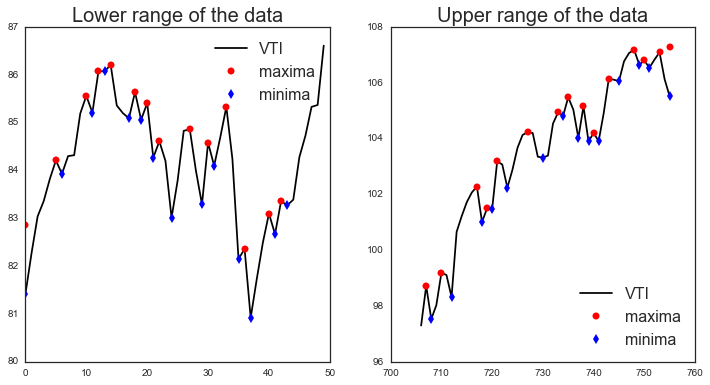

In [21]:
boundary_N = -50
restricted_t = dummy_t[boundary_N]
bnd_max_t = maxima_t > restricted_t
boundary_max_t = maxima_t[bnd_max_t]
boundary_max_x = maxima_x[bnd_max_t]

bnd_min_t = minima_t > restricted_t
boundary_min_t = minima_t[bnd_min_t]
boundary_min_x = minima_x[bnd_min_t]

boundary2_N = 50
restricted_t2 = dummy_t[boundary2_N]
bnd_max_t2 = maxima_t < restricted_t2
boundary_max_t2 = maxima_t[bnd_max_t2]
boundary_max_x2 = maxima_x[bnd_max_t2]

bnd_min_t2 = minima_t < restricted_t2
boundary_min_t2 = minima_t[bnd_min_t2]
boundary_min_x2 = minima_x[bnd_min_t2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(dummy_t[:boundary2_N], X0[:boundary2_N], color='k', label='VTI')
ax[0].plot(boundary_max_t2, boundary_max_x2, linewidth=0, marker='o', color='r', label='maxima')
ax[0].plot(boundary_min_t2, boundary_min_x2, linewidth=0, marker='d', color='b', label='minima')
ax[0].legend(fontsize=16, loc=1)
ax[0].set_title('Lower range of the data', fontsize=20)

ax[1].plot(dummy_t[boundary_N:], X0[boundary_N:], color='k', label='VTI')
ax[1].plot(boundary_max_t, boundary_max_x, linewidth=0, marker='o', color='r', label='maxima')
ax[1].plot(boundary_min_t, boundary_min_x, linewidth=0, marker='d', color='b', label='minima')
ax[1].legend(fontsize=16, loc=4)
ax[1].set_title('Upper range of the data', fontsize=20)

Now we can proceed fitting splines to our extrema to get envelopes, and then subtract the envelope mean out.

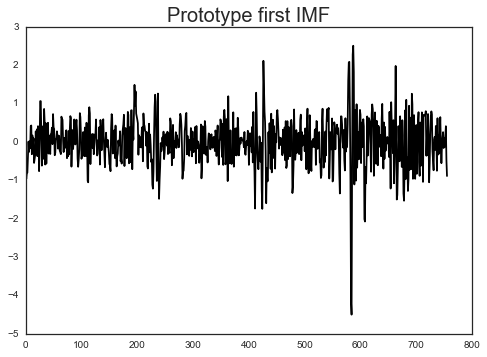

In [22]:
min_spline = sp.interpolate.interp1d(minima_t, minima_x, kind='cubic')
max_spline = sp.interpolate.interp1d(maxima_t, maxima_x, kind='cubic')

m1 = (max_spline(dummy_t) + min_spline(dummy_t))/2
h1 = X0 - m1

plt.plot(dummy_t, h1, color='k')
plt.title("Prototype first IMF", fontsize=20)

This is much better, but we should subtract out the envelope mean a few more times to see the signal settle in place.

In [23]:
def HHT_IMF_prototype(t, x, Niter=5, verbose=False):
    N = len(t)
    out_x = np.zeros((N, Niter))
    for idx in range(Niter):
        if verbose:
            print('Running %d of %d' % (idx + 1, Niter))
        
        minima_x, minima_t, maxima_x, maxima_t = get_IMF_extrema(t, x)
        if minima_x is None:
            raise ValueError('Signal given should be your residue.')
        
        if len(minima_t) != 3:
            min_spline = sp.interpolate.interp1d(minima_t, minima_x, kind='cubic')
        else:
            # You need 4 points for a cubic spline, so use quadratic
            min_spline = sp.interpolate.interp1d(minima_t, minima_x, kind='quadratic')
        
        if len(maxima_t) != 3:
            max_spline = sp.interpolate.interp1d(maxima_t, maxima_x, kind='cubic')
        else:
            max_spline = sp.interpolate.interp1d(maxima_t, maxima_x, kind='quadratic')

        env_mean = (min_spline(t) + max_spline(t))/2
        x = x - env_mean
        out_x[:, idx] = x
    return out_x

In [24]:
h1_series = HHT_IMF_prototype(dummy_t, h1, Niter=5, verbose=True)

Running 1 of 5
Running 2 of 5
Running 3 of 5
Running 4 of 5
Running 5 of 5


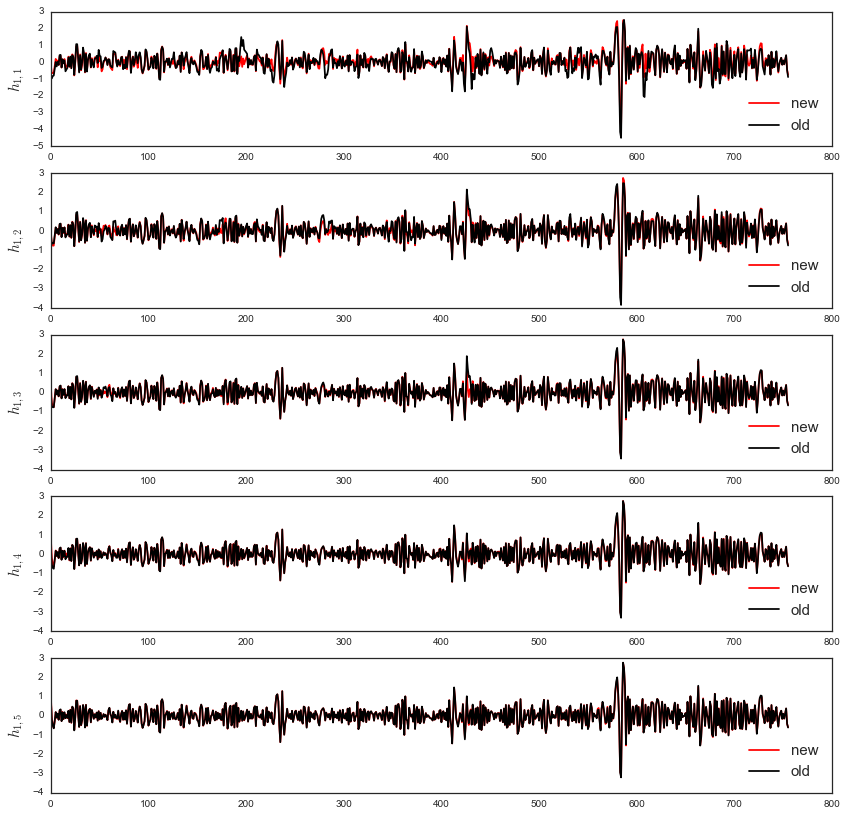

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14,14))
axes[0].plot(dummy_t, h1_series[:,0], color='r', label='new')
axes[0].plot(dummy_t, h1, color='k', label='old')
axes[0].legend(fontsize=15, loc=4)
axes[0].set_ylabel(r"$h_{1,1}$", fontsize=15)
axes[1].plot(dummy_t, h1_series[:,1], color='r', label='new')
axes[1].plot(dummy_t, h1_series[:,0], color='k', label='old')
axes[1].legend(fontsize=15, loc=4)
axes[1].set_ylabel(r"$h_{1,2}$", fontsize=15)
axes[2].plot(dummy_t, h1_series[:,2], color='r', label='new')
axes[2].plot(dummy_t, h1_series[:,1], color='k', label='old')
axes[2].legend(fontsize=15, loc=4)
axes[2].set_ylabel(r"$h_{1,3}$", fontsize=15)
axes[3].plot(dummy_t, h1_series[:,3], color='r', label='new')
axes[3].plot(dummy_t, h1_series[:,2], color='k', label='old')
axes[3].legend(fontsize=15, loc=4)
axes[3].set_ylabel(r"$h_{1,4}$", fontsize=15)
axes[4].plot(dummy_t, h1_series[:,4], color='r', label='new')
axes[4].plot(dummy_t, h1_series[:,3], color='k', label='old')
axes[4].legend(fontsize=15, loc=4)
axes[4].set_ylabel(r"$h_{1,5}$", fontsize=15)

By the 5th iteration, it looks like the signal is pretty static, so we'll say that we've settled on the first IMF ($h_{1,5}$).

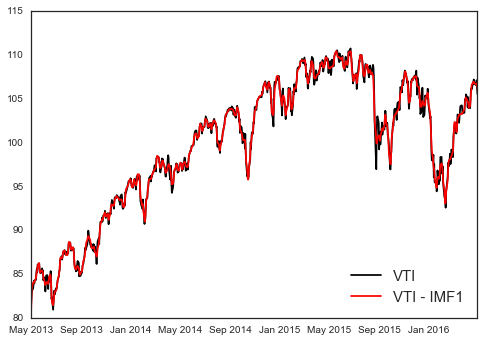

In [26]:
IMF1 = h1_series[:,-1]
X1 = X0 - IMF1

plt.plot(vti_dates, X0, color='k', label='VTI')
plt.plot(vti_dates, X1, color='r', label='VTI - IMF1')
plt.legend(fontsize=15, loc=4)

So the remaining signal has much of the high-frequency stuff filtered out.

Repeating this again...

In [27]:
h2_series = HHT_IMF_prototype(dummy_t, X1, Niter=6, verbose=True)

Running 1 of 6
Running 2 of 6
Running 3 of 6
Running 4 of 6
Running 5 of 6
Running 6 of 6


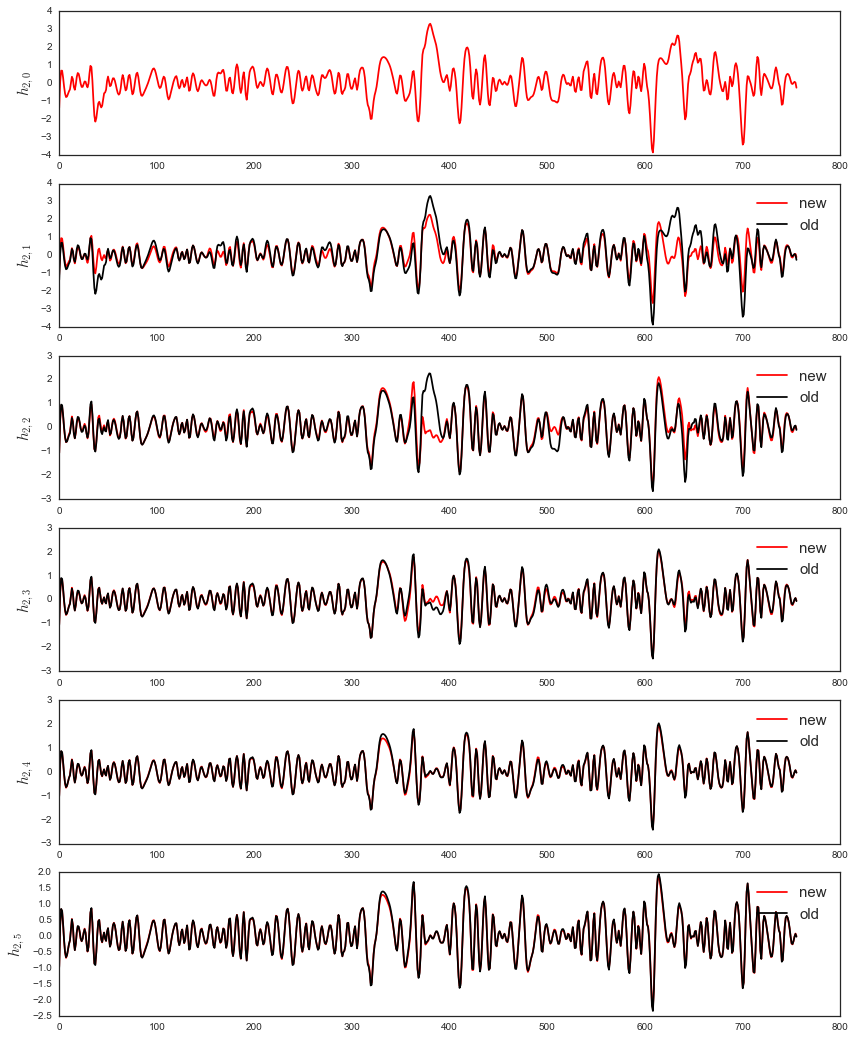

In [28]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(14,18))
axes[0].plot(dummy_t, h2_series[:,0], color='r')
axes[0].set_ylabel(r"$h_{2,0}$", fontsize=15)
axes[1].plot(dummy_t, h2_series[:,1], color='r', label='new')
axes[1].plot(dummy_t, h2_series[:,0], color='k', label='old')
axes[1].legend(fontsize=15)
axes[1].set_ylabel(r"$h_{2,1}$", fontsize=15)
axes[2].plot(dummy_t, h2_series[:,2], color='r', label='new')
axes[2].plot(dummy_t, h2_series[:,1], color='k', label='old')
axes[2].legend(fontsize=15)
axes[2].set_ylabel(r"$h_{2,2}$", fontsize=15)
axes[3].plot(dummy_t, h2_series[:,3], color='r', label='new')
axes[3].plot(dummy_t, h2_series[:,2], color='k', label='old')
axes[3].legend(fontsize=15)
axes[3].set_ylabel(r"$h_{2,3}$", fontsize=15)
axes[4].plot(dummy_t, h2_series[:,4], color='r', label='new')
axes[4].plot(dummy_t, h2_series[:,3], color='k', label='old')
axes[4].legend(fontsize=15)
axes[4].set_ylabel(r"$h_{2,4}$", fontsize=15)
axes[5].plot(dummy_t, h2_series[:,5], color='r', label='new')
axes[5].plot(dummy_t, h2_series[:,4], color='k', label='old')
axes[5].legend(fontsize=15)
axes[5].set_ylabel(r"$h_{2,5}$", fontsize=15)

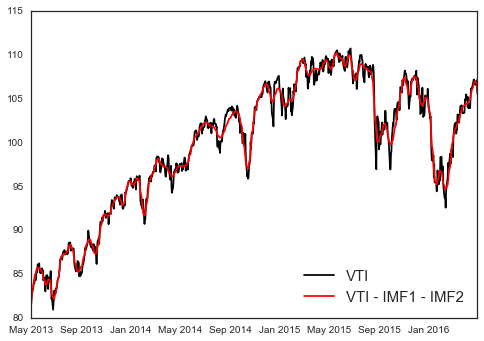

In [29]:
IMF2 = h2_series[:,-1]
X2 = X1 - IMF2

plt.plot(vti_dates, X0, color='k', label='VTI')
plt.plot(vti_dates, X2, color='r', label='VTI - IMF1 - IMF2')
plt.legend(fontsize=15, loc=4)

I want to automate this process more, so I'll now use the S stoppage rule (number of extrema and zero-crossings within one of each other, number of extrema and zero crossings does not change for 5 iterations).

In [30]:
def calculate_next_IMF(X_i, S_finish=5, maxiter=50, extra_verbose=False):
    print("Calulating h_i0")
    t = np.arange(len(X_i))
    S_accum = 0
    h_i = HHT_IMF_prototype(t, X_i, Niter=1).ravel()

    # Find number of maxima and zero crossings
    minima = sp.signal.argrelmin(h_i)
    if isinstance(minima, tuple):
        minima = minima[0]
    maxima = sp.signal.argrelmax(h_i)[0]
    if isinstance(maxima, tuple):
        maxima = maxima[0]
    # argrel doesn't pick points on the boundaries, fortunately
    zerocrossdown = np.logical_and(h_i[:-1] >= 0, h_i[1:] < 0)
    zerocrossup = np.logical_and(h_i[:-1] <= 0, h_i[1:] > 0)
    
    numextrema = len(minima) + len(maxima)
    numzeros = sum(zerocrossdown) + sum(zerocrossup)
    old_numextrema = numextrema
    old_numzeros = numzeros
    
    idx = 1
    while S_accum < S_finish:
        print("Beginning iter %s" % idx)
        
        h_i = HHT_IMF_prototype(t, h_i, Niter=1, verbose=extra_verbose).ravel()
        
        minima = sp.signal.argrelmin(h_i)
        if isinstance(minima, tuple):
            minima = minima[0]
        maxima = sp.signal.argrelmax(h_i)
        if isinstance(maxima, tuple):
            maxima = maxima[0]
        zerocrossdown = np.logical_and(h_i[:-1] >= 0, h_i[1:] < 0)
        zerocrossup = np.logical_and(h_i[:-1] <= 0, h_i[1:] > 0)
    
        numextrema = len(minima) + len(maxima)
        numzeros = sum(zerocrossdown) + sum(zerocrossup)
        
        test1 = np.abs(numextrema - numzeros) <= 1
        test2 = numextrema == old_numextrema
        test3 = numzeros == old_numzeros
        
        old_numextrema = numextrema
        old_numzeros = numzeros
        
        if test1 and test2 and test3:
            print("Passed S")
            S_accum += 1
        else:
            print("Failed S")
            S_accum = 0
        if idx == maxiter:
            print("Reached maxiter")
            break
        idx += 1
    return h_i, idx

In [31]:
# Redoing the calc of IMF1 and 2 above, since it's difficult to check IMF1 by eye
# to ensure we're stopping appropriately.
IMF1, _ = calculate_next_IMF(X0)
X1 = X0 - IMF1
IMF2, _ = calculate_next_IMF(X1)
X1 = X0 - IMF1

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Failed S
Beginning iter 3
Failed S
Beginning iter 4
Failed S
Beginning iter 5
Passed S
Beginning iter 6
Failed S
Beginning iter 7
Passed S
Beginning iter 8
Passed S
Beginning iter 9
Passed S
Beginning iter 10
Failed S
Beginning iter 11
Failed S
Beginning iter 12
Failed S
Beginning iter 13
Failed S
Beginning iter 14
Failed S
Beginning iter 15
Failed S
Beginning iter 16
Failed S
Beginning iter 17
Failed S
Beginning iter 18
Failed S
Beginning iter 19
Passed S
Beginning iter 20
Failed S
Beginning iter 21
Failed S
Beginning iter 22
Passed S
Beginning iter 23
Passed S
Beginning iter 24
Passed S
Beginning iter 25
Passed S
Beginning iter 26
Passed S
Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Failed S
Beginning iter 3
Failed S
Beginning iter 4
Failed S
Beginning iter 5
Failed S
Beginning iter 6
Failed S
Beginning iter 7
Failed S
Beginning iter 8
Passed S
Beginning iter 9
Passed S
Beginning iter 10
Failed S
Beginning iter

In [32]:
IMF3, _ = calculate_next_IMF(X2)

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Failed S
Beginning iter 3
Failed S
Beginning iter 4
Failed S
Beginning iter 5
Failed S
Beginning iter 6
Failed S
Beginning iter 7
Failed S
Beginning iter 8
Passed S
Beginning iter 9
Failed S
Beginning iter 10
Failed S
Beginning iter 11
Failed S
Beginning iter 12
Failed S
Beginning iter 13
Failed S
Beginning iter 14
Failed S
Beginning iter 15
Failed S
Beginning iter 16
Failed S
Beginning iter 17
Failed S
Beginning iter 18
Failed S
Beginning iter 19
Failed S
Beginning iter 20
Failed S
Beginning iter 21
Failed S
Beginning iter 22
Failed S
Beginning iter 23
Failed S
Beginning iter 24
Failed S
Beginning iter 25
Failed S
Beginning iter 26
Passed S
Beginning iter 27
Failed S
Beginning iter 28
Failed S
Beginning iter 29
Passed S
Beginning iter 30
Passed S
Beginning iter 31
Failed S
Beginning iter 32
Failed S
Beginning iter 33
Failed S
Beginning iter 34
Passed S
Beginning iter 35
Passed S
Beginning iter 36
Passed S
Beginning iter 37
Pas

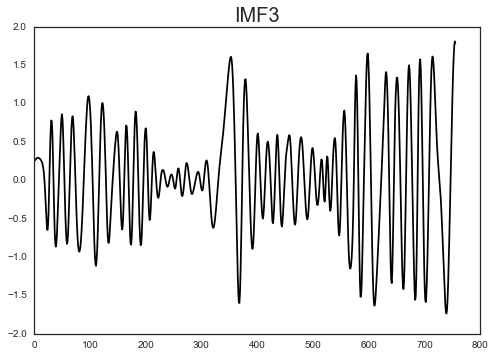

In [33]:
plt.plot(dummy_t, IMF3, color='k')
plt.title("IMF3", fontsize=20)

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Passed S
Beginning iter 3
Passed S
Beginning iter 4
Passed S
Beginning iter 5
Passed S
Beginning iter 6
Passed S


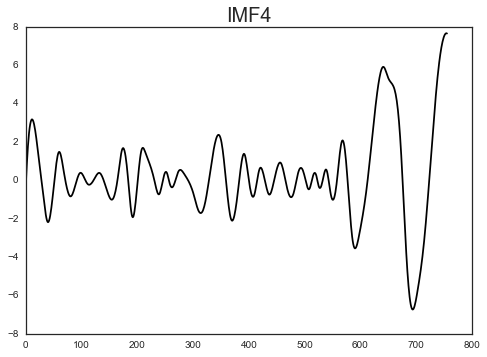

In [34]:
X3 = X2 - IMF3
IMF4, _ = calculate_next_IMF(X3)
plt.plot(dummy_t, IMF4, color='k')
plt.title("IMF4", fontsize=20)

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Passed S
Beginning iter 3
Passed S
Beginning iter 4
Passed S
Beginning iter 5
Passed S
Beginning iter 6
Passed S


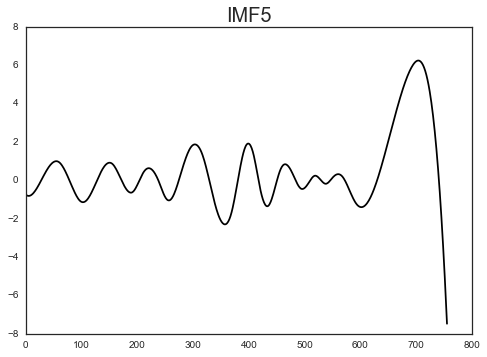

In [35]:
X4 = X3 - IMF4
IMF5, _ = calculate_next_IMF(X4)
plt.plot(dummy_t, IMF5, color='k')
plt.title("IMF5", fontsize=20)

(array([695]),)
(array([519]),)
(756,)


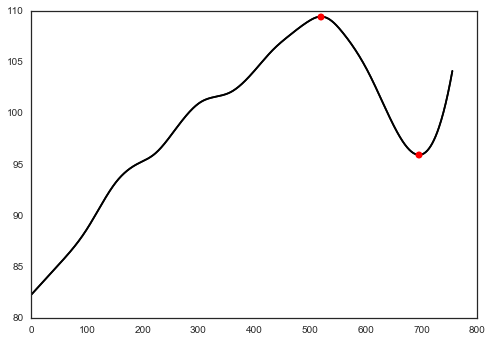

In [36]:
X5 = X4 - IMF5
plt.plot(dummy_t, X5, color='k')

print(sp.signal.argrelmin(X5))
print(sp.signal.argrelmax(X5))
plt.plot(dummy_t, X5, 'k')
plt.plot(dummy_t[[519, 695]], X5[[519, 695]], linewidth=0, marker='o', color='r')
print(X5.shape)

We now have just two extrema left, so the next IMF will be our last one.

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Failed S
Beginning iter 3
Failed S
Beginning iter 4
Failed S
Beginning iter 5
Passed S
Beginning iter 6
Passed S
Beginning iter 7
Passed S
Beginning iter 8
Passed S
Beginning iter 9
Passed S


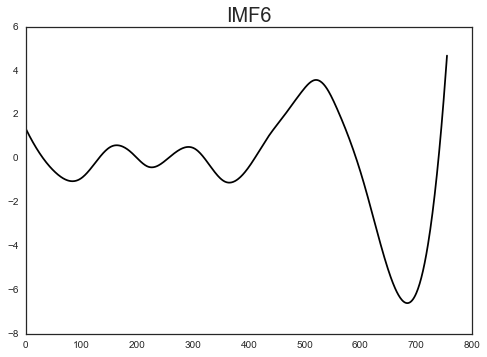

In [37]:
IMF6, _ = calculate_next_IMF(X5)
plt.plot(dummy_t, IMF6, color='k')
plt.title("IMF6", fontsize=20)

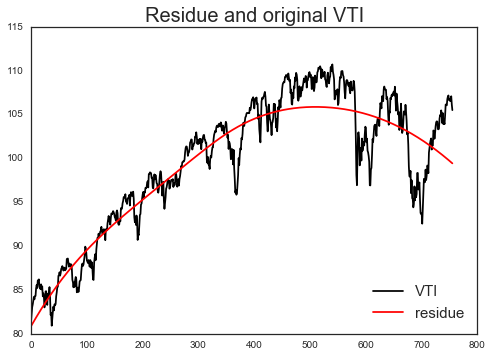

In [38]:
residue = X5 - IMF6
plt.plot(dummy_t, X0, color='k', label="VTI")
plt.plot(dummy_t, residue, color='r', label="residue")
plt.legend(fontsize=15, loc=4)
plt.title("Residue and original VTI", fontsize=20)

Plotting everything:

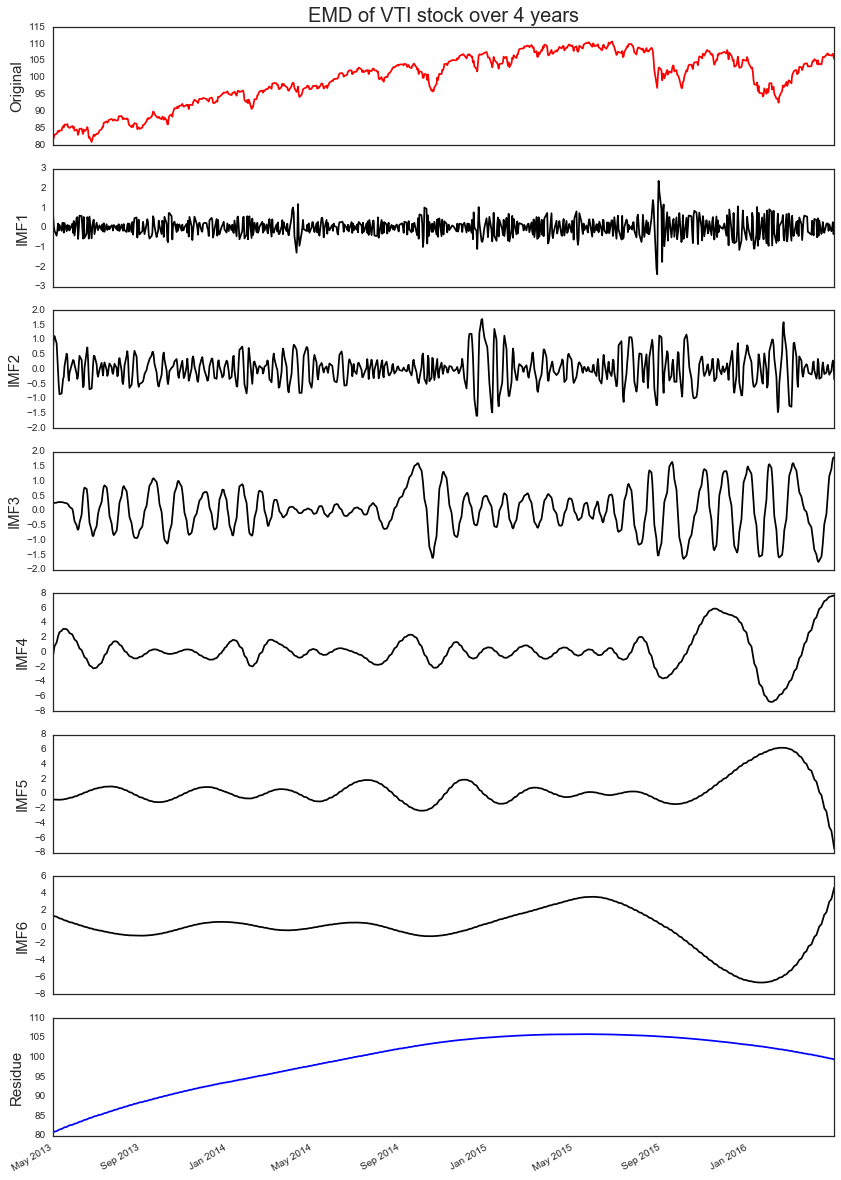

In [39]:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(14,22))
axes[0].plot(vti_dates, X0, color='r')
axes[0].set_ylabel("Original", fontsize=15)
axes[0].set_title("EMD of VTI stock over 4 years", fontsize=20)
axes[1].plot(vti_dates, IMF1, color='k')
axes[1].set_ylabel(r"IMF1", fontsize=15)

axes[2].plot(vti_dates, IMF2, color='k')
axes[2].set_ylabel(r"IMF2", fontsize=15)

axes[3].plot(vti_dates, IMF3, color='k')
axes[3].set_ylabel(r"IMF3", fontsize=15)

axes[4].plot(vti_dates, IMF4, color='k')
axes[4].set_ylabel(r"IMF4", fontsize=15)

axes[5].plot(vti_dates, IMF5, color='k')
axes[5].set_ylabel(r"IMF5", fontsize=15)

axes[6].plot(vti_dates, IMF6, color='k')
axes[6].set_ylabel(r"IMF6", fontsize=15)

axes[7].plot(vti_dates, residue, color='b')
axes[7].set_ylabel(r"Residue", fontsize=15)

fig.autofmt_xdate()

At this point the performance of VTI stock has been broken into 6 Hilbert-able frequency components.

Getting the frequency components...

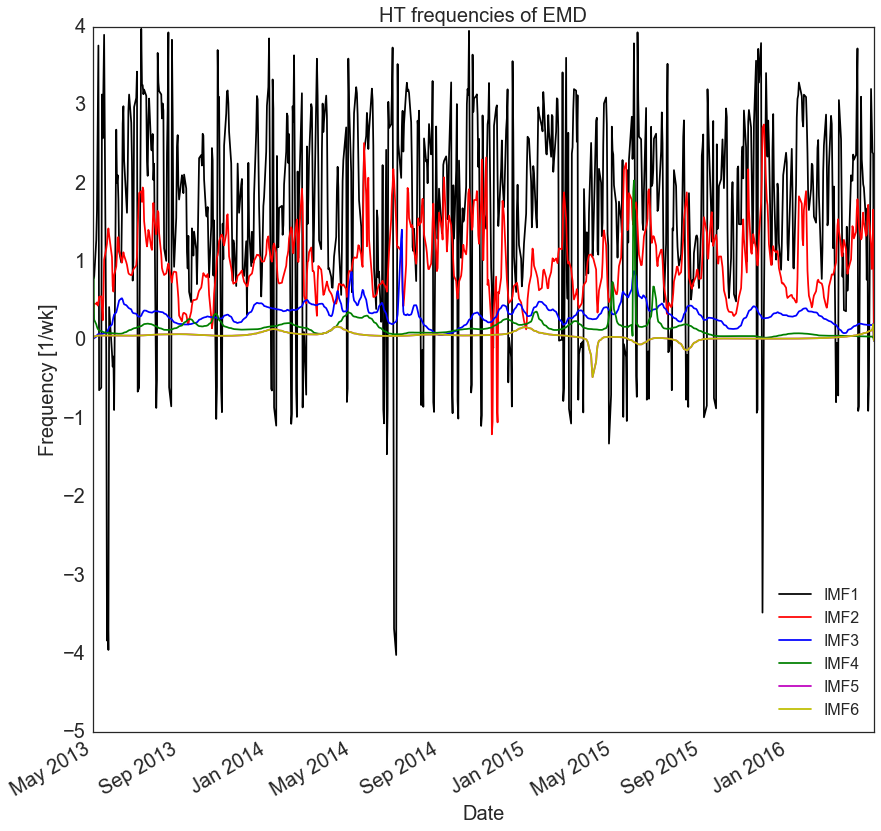

In [40]:
IMF_hil = mirror_hilbert(IMF1, reflect_x=False)

env1 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
# phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq1 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
# delta = 1 day. I'm going to multiply by 7 to get weekly freqs for something a bit
# more human readable

# The Hilbert signal we're getting here jumps below 0 at some times still. For this,
# we clip below min_freq_thresh
# min_freq_thresh = 0.005
# Trying to clean out more weird bits, I'm use one final SG filter to clean out neg signals
# freq1 = savgol_filter(freq1, 7, 3, deriv=0, mode='mirror')
# freq1[freq1 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF2, reflect_x=False)

env2 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
# phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq2 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
# freq2 = savgol_filter(freq2, 5, 3, deriv=0, mode='mirror')
# freq2[freq2 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF3, reflect_x=False)

env3 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
# phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq3 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
# freq3 = savgol_filter(freq3, 5, 3, deriv=0, mode='mirror')
# freq3[freq3 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF4, reflect_x=False)

env4 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
# phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq4 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
# freq4 = savgol_filter(freq4, 5, 3, deriv=0, mode='mirror')
# freq4[freq4 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF5, reflect_x=False)

env5 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
# phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq5 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
# freq5 = savgol_filter(freq5, 5, 3, deriv=0, mode='mirror')
# freq5[freq5 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF6, reflect_x=False)

env6 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
freq6 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
axes.plot(vti_dates, freq1, color='k', label='IMF1')
axes.plot(vti_dates, freq2, color='r', label='IMF2')
axes.plot(vti_dates, freq3, color='b', label='IMF3')
axes.plot(vti_dates, freq4, color='g', label='IMF4')
axes.plot(vti_dates, freq5, color='m', label='IMF5')
axes.plot(vti_dates, freq5, color='y', label='IMF6')
axes.set_xlabel("Date", fontsize=20)
axes.set_ylabel("Frequency [1/wk]", fontsize=20)
axes.set_title("HT frequencies of EMD", fontsize=20)
axes.tick_params(labelsize=20)
axes.legend(fontsize=16, loc=4)

fig.autofmt_xdate()

Well, that's disappointing--we seem to have some nice-ish looking parts, but then we also have violent spikes in the frequencies. These signals aren't so Hilbertable after all! :(

### A footnote comes back to haunt us...

I mentioned in a footnote far above (when introducing the analytic signal) that our inferring the instantaneous frequency from $\tilde{f}(t) = A(t)e^{i \theta(t) t}$ only works properly if the frequency content of $A(t)$ and $e^{i \theta(t) t}$ have no overlap (due to the Bedrosian Theorem). So what happens when we try and plot the inferred envelope with the signal?

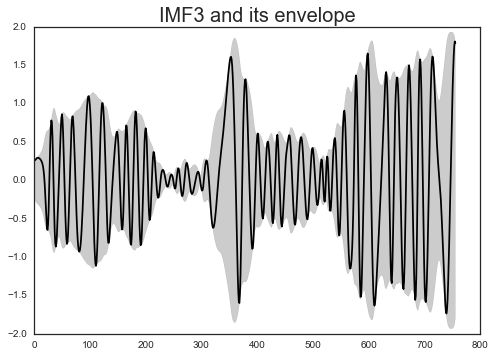

In [41]:
plt.plot(dummy_t, IMF3, color='k')
plt.fill_between(dummy_t, -env3, env3, color='k', alpha=0.2)
plt.title('IMF3 and its envelope', fontsize=20)

No bueno. We can easily see the envelope is bouncing around with the same frequency as the IMF itself.

To get around this issue, some further work is to be done on our IMFs. Since we need the frequency content of envelope to be disjoint from the frequency content of the oscillating signal, we will first try and munge our signal into something that's normalized (a constant envelope of size 1), compute the instantaneous frequency from there, and then back out to get the envelope.

The process goes as follows:
1. Take the absolute value of the IMF, and find all its maxima.
2. Fit a cubic spline to the maxima (we'll call it $e_1$).
3. Divide the IMF by $e_1$. The signal should mostly oscillate between -1 and 1, but there may be some bits that exceed this (if the spline happened to go beneath a signal).
4. Repeat the process above (getting splines $e_2, e_3, ..., e_n$ until all of the signal lies between -1 and 1. This generally only takes a few tries.

After this whole process, your envelope $A(t)$ is the product $e_1 \times ... \times e_n$ and the frequency signal is the IMF divided by $A$. Analogous to radio signals, we call the envelope the AM (amplitude modulation) signal and the frequency signal the FM signal.

In [42]:
absIMF3 = np.abs(IMF3)
_, _, maxima_x, maxima_t = get_IMF_extrema(dummy_t, absIMF3)
e1fn = sp.interpolate.interp1d(maxima_t, maxima_x, kind='cubic')
e1 = e1fn(dummy_t)

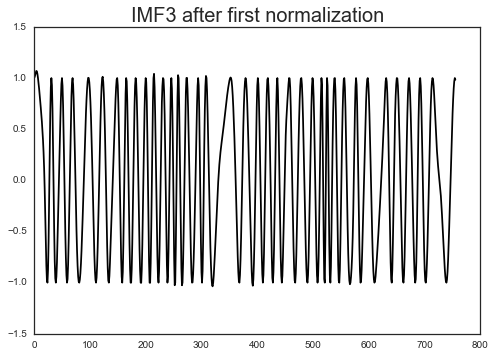

In [43]:
plt.plot(dummy_t, IMF3/e1, color='k')
plt.title('IMF3 after first normalization', fontsize=20)

In [44]:
def split_IMF_to_AM_FM(dummy_t, IMF, max_iter=10, verbose=True):
    IMForiginal = np.copy(IMF)
    N = len(dummy_t)
    en_array = np.ones((N, max_iter))
    
    for idx in range(max_iter):
        if verbose:
            print('Running normalization %d' % (idx + 1))
        IMFabs = np.abs(IMF)
        _, _, maxima_x, maxima_t = get_IMF_extrema(dummy_t, IMFabs)
        en_fn = sp.interpolate.interp1d(maxima_t, maxima_x, kind='cubic')
        e_n = en_fn(dummy_t)
        IMF = IMF/e_n
        en_array[:, idx] = e_n
        if all(np.abs(IMF) <= 1 + 1E-9):
            # Added tolerance value, otherwise it doesn't stop
            maximf = np.max(IMF)
            IMF = IMF/maximf
            break
        if idx == max_iter - 1:
            print('Reached max_iter')
    FM = IMF
    AM = np.prod(en_array, axis=1)
    return AM, FM

In [45]:
AM, FM = split_IMF_to_AM_FM(dummy_t, IMF3)

Running normalization 1
Running normalization 2
Running normalization 3


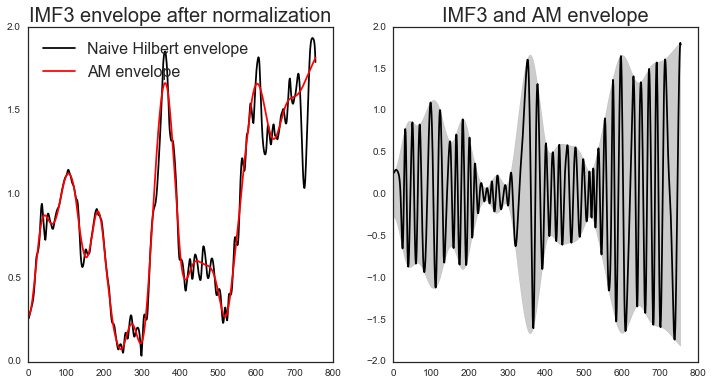

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].plot(dummy_t, env3, color='k', label='Naive Hilbert envelope')
ax[0].plot(dummy_t, AM, color='r', label='AM envelope')
ax[0].legend(fontsize=16, loc=2)
ax[0].set_title("IMF3 envelope after normalization", fontsize=20)

ax[1].plot(dummy_t, IMF3, color='k', label='IMF')
ax[1].fill_between(dummy_t, -AM, AM, color='k', alpha=0.2)
ax[1].set_title("IMF3 and AM envelope", fontsize=20)

This is much better.

### Two methods of getting instantaneous frequency

(For a deeper look Huang et al.'s paper "On Instantaneous Frequency" ([link](http://www.worldscientific.com/doi/abs/10.1142/S1793536909000096)))

Now that we have a normalized FM signal, we have a few different methods available to us to process it.

First, we can finally use the Hilbert Transform on the normalized signal, confident now that the envelope won't look like a phase component to the transform. This technique is called the __Normalized Hilbert Transform (NHT)__. However, we still have some of the problems we saw at the beginning of boundaries still being a bit weird (and since we're integrating over the whole signal, this affects everything.

A different technique, called __Direct Quadrature (DQ)__ avoids this, and is currently the technique most in use. If we assume that our normalized signal has some form $F(t) = \cos(\phi(t))$ (for some unknown $\phi(t)$), we assume there's some complementary signal $G(t) = \sin(\phi(t))$. Now, the trick is just to find $\phi$. You could take the arccosine of $F$, but it ends up being easier if you take

$$\phi(t) = \arctan \left( \frac{G}{F}\right) = \arctan \left( \frac{\sqrt{1 - F^2}}{F}\right)$$

and then upwrap $\phi$ as necessary.

I realize that, after a long process of dealing with Hilbert Transforms, we've arrived at an algorithm that actually doesn't have a Hilbert Transform in it. I hope we can all appreciate the irony in this situation.

With that said, for the sake of quick illustration I'll use the NHT instead of DQ to get the frequency content of VTI.

In [47]:
NHT = mirror_hilbert(FM)

phaseterm = np.unwrap(np.angle(NHT))
instant_freq_FM = 7*savgol_filter(phaseterm, 3, 1, deriv=1, delta=1, mode='mirror')/(2*np.pi)

IMF_hil = mirror_hilbert(IMF3, reflect_x=False)
phase = np.unwrap(np.angle(IMF_hil))
instant_freq_HT = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)

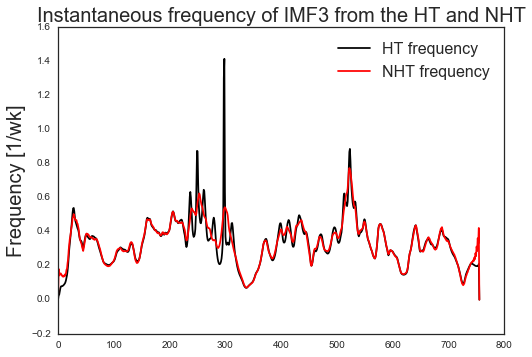

In [48]:
plt.plot(dummy_t, instant_freq_HT, color='k', label='HT frequency')
plt.plot(dummy_t, instant_freq_FM, color='r', label='NHT frequency')
plt.ylabel('Frequency [1/wk]', fontsize=20)
plt.legend(fontsize=16)
plt.title('Instantaneous frequency of IMF3 from the HT and NHT', fontsize=20)

As you can see, the NHT's frequency is much better behaved, without the sudden spikes. If we used Direct Quadrature, this would be even better.

In [49]:
AM1, FM = split_IMF_to_AM_FM(dummy_t, IMF1)
NHT = mirror_hilbert(FM)
phaseterm = np.unwrap(np.angle(NHT))
instant_freq_FM1 = 7*savgol_filter(phaseterm, 3, 1, deriv=1, delta=1, mode='mirror')/(2*np.pi)

AM2, FM = split_IMF_to_AM_FM(dummy_t, IMF2)
NHT = mirror_hilbert(FM)
phaseterm = np.unwrap(np.angle(NHT))
instant_freq_FM2 = 7*savgol_filter(phaseterm, 3, 1, deriv=1, delta=1, mode='mirror')/(2*np.pi)

AM3, FM = split_IMF_to_AM_FM(dummy_t, IMF3)
NHT = mirror_hilbert(FM)
phaseterm = np.unwrap(np.angle(NHT))
instant_freq_FM3 = 7*savgol_filter(phaseterm, 3, 1, deriv=1, delta=1, mode='mirror')/(2*np.pi)

AM4, FM = split_IMF_to_AM_FM(dummy_t, IMF4)
NHT = mirror_hilbert(FM)
phaseterm = np.unwrap(np.angle(NHT))
instant_freq_FM4 = 7*savgol_filter(phaseterm, 3, 1, deriv=1, delta=1, mode='mirror')/(2*np.pi)

AM5, FM = split_IMF_to_AM_FM(dummy_t, IMF5)
NHT = mirror_hilbert(FM)
phaseterm = np.unwrap(np.angle(NHT))
instant_freq_FM5 = 7*savgol_filter(phaseterm, 3, 1, deriv=1, delta=1, mode='mirror')/(2*np.pi)

AM6, FM = split_IMF_to_AM_FM(dummy_t, IMF6)
NHT = mirror_hilbert(FM)
phaseterm = np.unwrap(np.angle(NHT))
instant_freq_FM6 = 7*savgol_filter(phaseterm, 3, 1, deriv=1, delta=1, mode='mirror')/(2*np.pi)

Running normalization 1
Running normalization 2
Running normalization 3
Running normalization 4
Running normalization 1
Running normalization 2
Running normalization 3
Running normalization 1
Running normalization 2
Running normalization 3
Running normalization 1
Running normalization 2
Running normalization 3
Running normalization 1
Running normalization 2
Running normalization 3
Running normalization 1
Running normalization 2


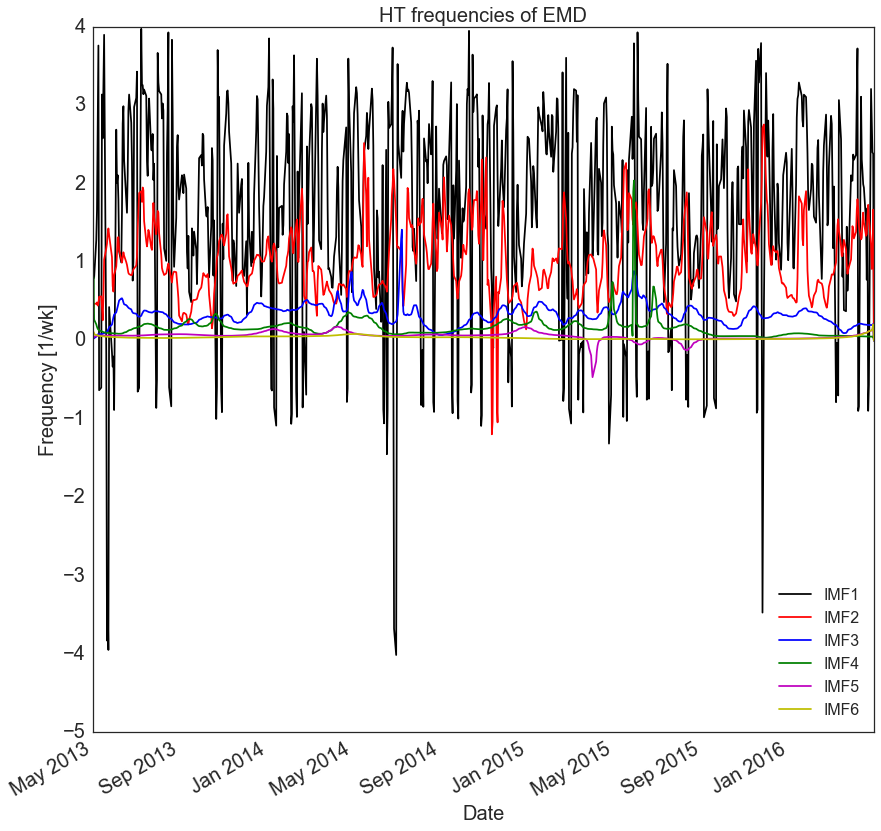

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
axes.plot(vti_dates, freq1, color='k', label='IMF1')
axes.plot(vti_dates, freq2, color='r', label='IMF2')
axes.plot(vti_dates, freq3, color='b', label='IMF3')
axes.plot(vti_dates, freq4, color='g', label='IMF4')
axes.plot(vti_dates, freq5, color='m', label='IMF5')
axes.plot(vti_dates, freq6, color='y', label='IMF6')
axes.set_xlabel("Date", fontsize=20)
axes.set_ylabel("Frequency [1/wk]", fontsize=20)
axes.set_title("HT frequencies of EMD", fontsize=20)
axes.tick_params(labelsize=20)
axes.legend(fontsize=16, loc=4)

fig.autofmt_xdate()

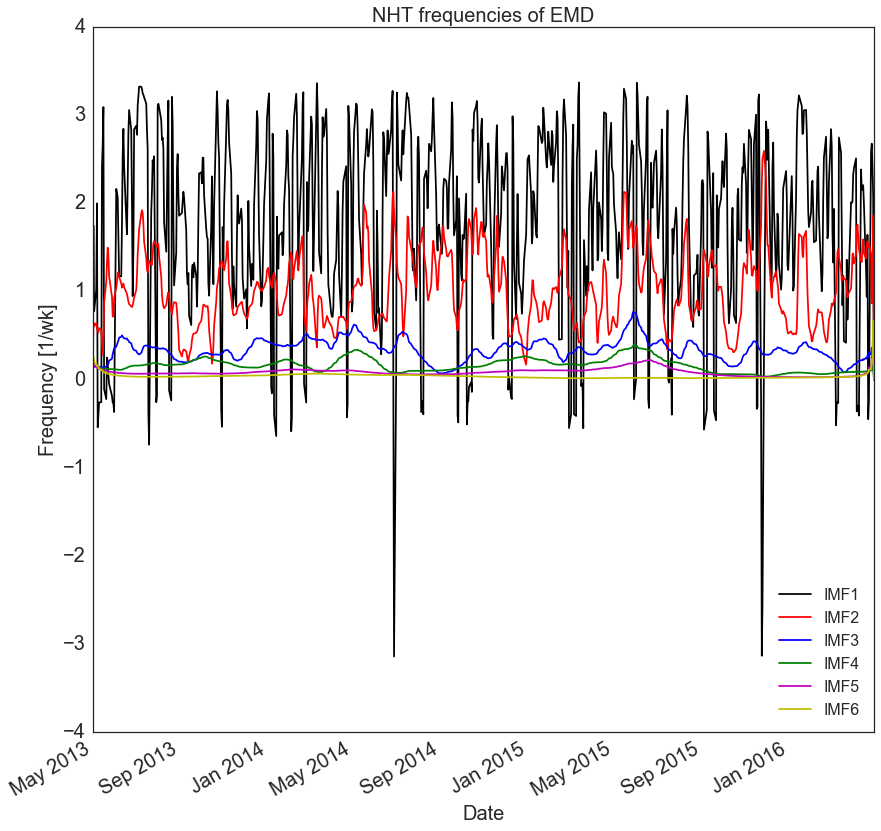

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
axes.plot(vti_dates, instant_freq_FM1, color='k', label='IMF1')
axes.plot(vti_dates, instant_freq_FM2, color='r', label='IMF2')
axes.plot(vti_dates, instant_freq_FM3, color='b', label='IMF3')
axes.plot(vti_dates, instant_freq_FM4, color='g', label='IMF4')
axes.plot(vti_dates, instant_freq_FM5, color='m', label='IMF5')
axes.plot(vti_dates, instant_freq_FM6, color='y', label='IMF6')
axes.set_xlabel("Date", fontsize=20)
axes.set_ylabel("Frequency [1/wk]", fontsize=20)
axes.set_title("NHT frequencies of EMD", fontsize=20)
axes.tick_params(labelsize=20)
axes.legend(fontsize=16, loc=4)

fig.autofmt_xdate()

While the first IMF still has instability, it's much better (and we should probably impute points and use DQ to clean it up further). Meanwhile, the rest of the instantaneous frequencies look much better. Now, plotting in log-y (without IMF1).

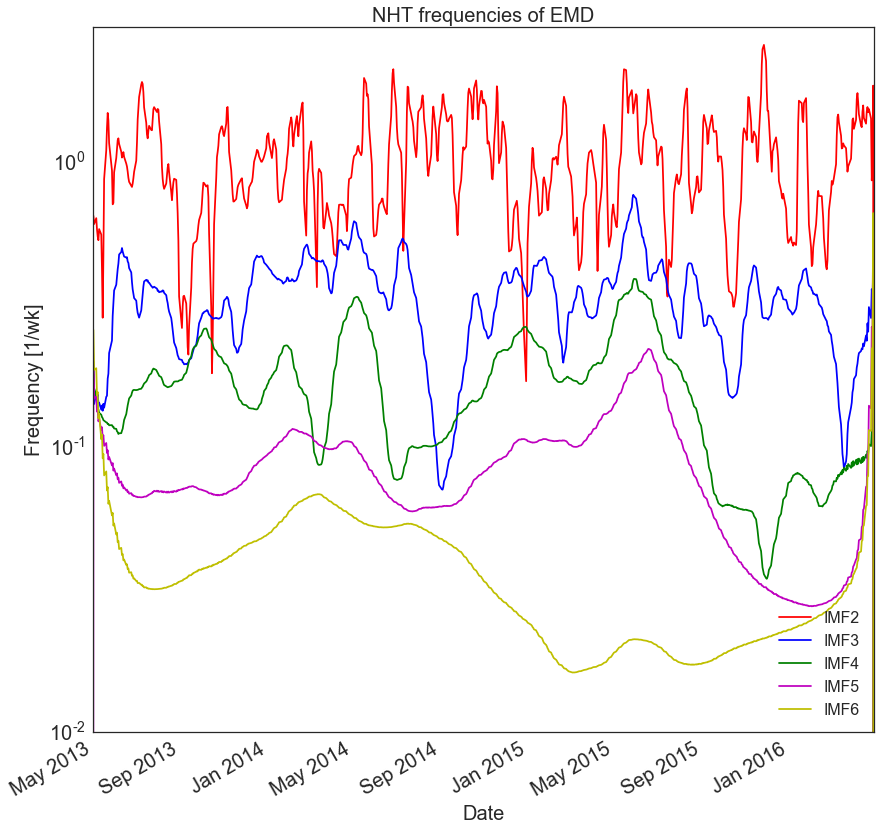

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
# axes.plot(vti_dates, instant_freq_FM1, color='k', label='IMF1')
axes.semilogy(vti_dates, instant_freq_FM2, color='r', label='IMF2')
axes.semilogy(vti_dates, instant_freq_FM3, color='b', label='IMF3')
axes.semilogy(vti_dates, instant_freq_FM4, color='g', label='IMF4')
axes.semilogy(vti_dates, instant_freq_FM5, color='m', label='IMF5')
axes.semilogy(vti_dates, instant_freq_FM6, color='y', label='IMF6')
axes.set_xlabel("Date", fontsize=20)
axes.set_ylabel("Frequency [1/wk]", fontsize=20)
axes.set_title("NHT frequencies of EMD", fontsize=20)
axes.tick_params(labelsize=20)
axes.legend(fontsize=16, loc=4)
axes.set_ylim([1E-2, 0.3*1E1])

fig.autofmt_xdate()

We can pretty clearly see that IMF2 corresponds to approximately weekly variation, IMF3 to monthly, IMF5 about year-long, and a few other signals beside.

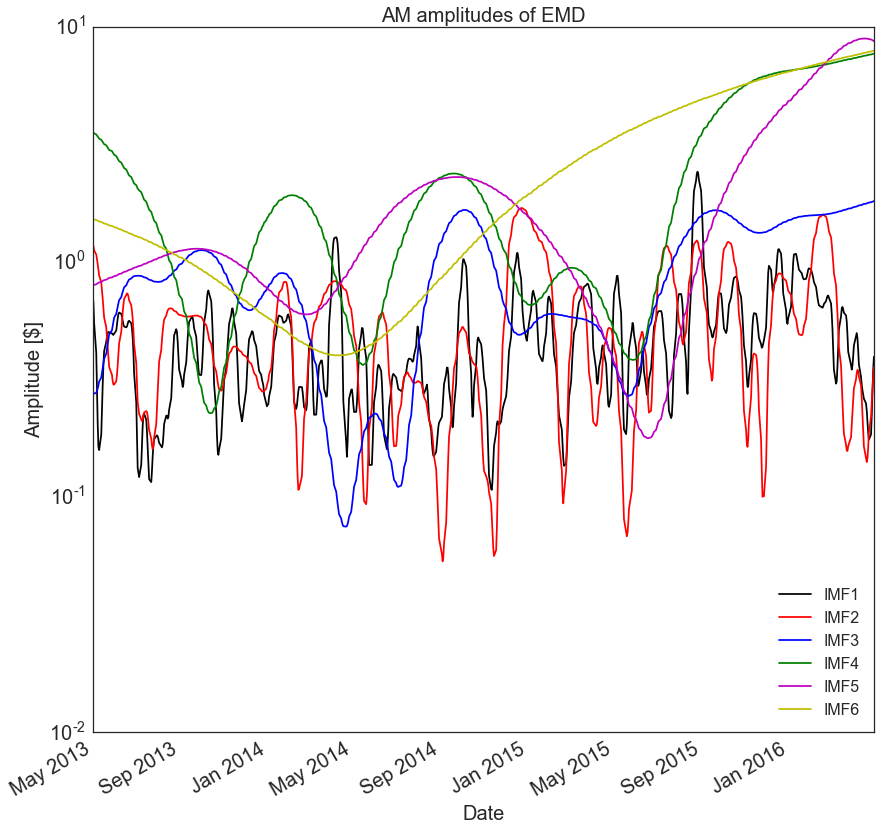

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
axes.semilogy(vti_dates, AM1, color='k', label='IMF1')
axes.semilogy(vti_dates, AM2, color='r', label='IMF2')
axes.semilogy(vti_dates, AM3, color='b', label='IMF3')
axes.semilogy(vti_dates, AM4, color='g', label='IMF4')
axes.semilogy(vti_dates, AM5, color='m', label='IMF5')
axes.semilogy(vti_dates, AM6, color='y', label='IMF6')
axes.set_xlabel("Date", fontsize=20)
axes.set_ylabel("Amplitude [$]", fontsize=20)
axes.set_title("AM amplitudes of EMD", fontsize=20)
axes.tick_params(labelsize=20)
axes.legend(fontsize=16, loc=4)
# axes.set_ylim([1E-2, 0.3*1E1])

fig.autofmt_xdate()

What do we learn? Well, some initial things I see:
- The [great stock sell-off around September 2015](https://en.wikipedia.org/wiki/2015_stock_market_selloff) is pretty clear in the highest-frequency IMF (IMF1). There's also some high-frequency action around May 2014, though I'm not finding any direct noise ([rapid-fire mergers and acquisitions](https://en.wikipedia.org/wiki/2015_stock_market_selloff)?).
- Outside of the above events, just by eyeing the amplitudes of the IMFs the high-frequency stuff is generally of less importance than the lower-frequency IMFs. But hey, we are looking at the broad markets, here.
- We can especially see the broad motions of VTI in the residue, with it peaking around summer of 2015.

### Further notes:

- Another major extension is the Ensemble Empirical Mode Decomposition (EEMD). For this technique, you add white-noise to the signal before you begin the EMD. Do this multiple times, and then average the IMFs together to cancel out the noise effects. This is especially useful if you have intermittant frequency signals, since those will play havoc with your IMFs.
- While using an arctangent for Direct Quadrature improves computational stability versus arccosine, it still may have trouble at the highest frequencies as the extrema may not map cleanly onto the data points. The authors recommends a 3-point-medium filter on the data, which seems to be unstandard terminology which I'm not seeing in the literature but which I assume means we might want to try and impute potential points using a LOESS strategy (e.g. with polynomials via Savitsky Golay).
- Once you've gotten your instantaneous frequencies and envelopes, you can calculate the marginal Hilbert spectrum as
$$H(\omega) = \int IMF(\omega, t) dt$$
  (IMF is zero unless we're at $\omega$, at which point you add the value of its envelope amplitude) to get the frequency content of the signal. This lets you know, as you add IMFs together, what frequencies you're including.
- There are [Python](https://pyhht.readthedocs.org/en/latest/) and [R](https://cran.r-project.org/web/packages/hht/index.html) packages to do the EMD for you.
- The EMD technique is currently under patent. For commercial use, you'll need to speak with NASA's Office of Technology Tranfer (patent numbers: 9013490, 8144331, 8913844, reference number GSC-TOPS-63).